# PyTorch Workflow Fundamentals

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn(neural network) containd all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

Data can be almost anything....

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data)
* Audio like songs or podcasts
* Text

Machine learning is a game of two parts:

1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.

To showcase this, let's create some *known* data using the linear regression formula.

We will use a linear regression formula to make a straight line with *known* **parameters.**

In [3]:
# Create *known* parameters
weight = 0.8
bias = 0.2

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2160],
         [0.2320],
         [0.2480],
         [0.2640],
         [0.2800],
         [0.2960],
         [0.3120],
         [0.3280],
         [0.3440]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [5]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

In [6]:
def plot_predictions(train_data = X_train,
                    train_labels = y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize = (10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    # Are there predictions?
    if predictions is not None:
        # Plot the predictions in red(predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    #Show the legend
    plt.legend(prop={"size": 14});
        

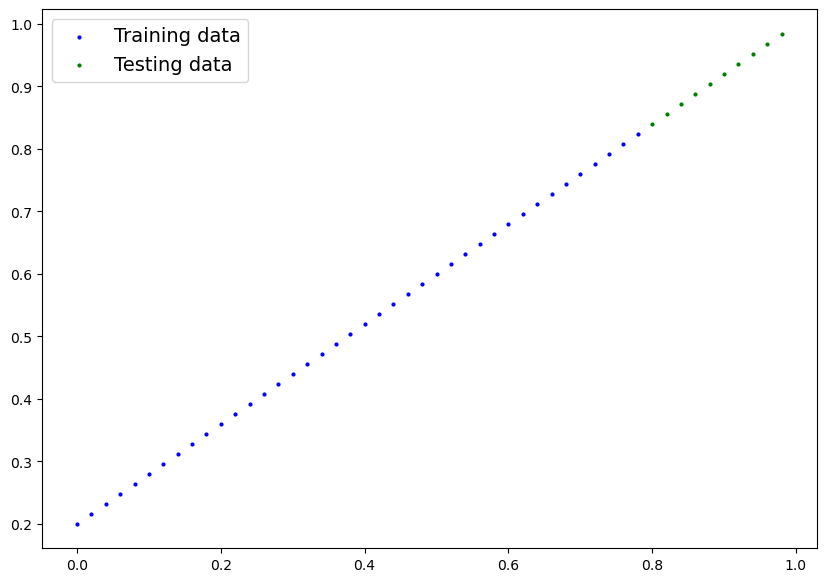

In [7]:
plot_predictions();

## 2. Build Model

In [8]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### Checking the contents of a PyTorch model

In [9]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()

In [11]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)



In [12]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


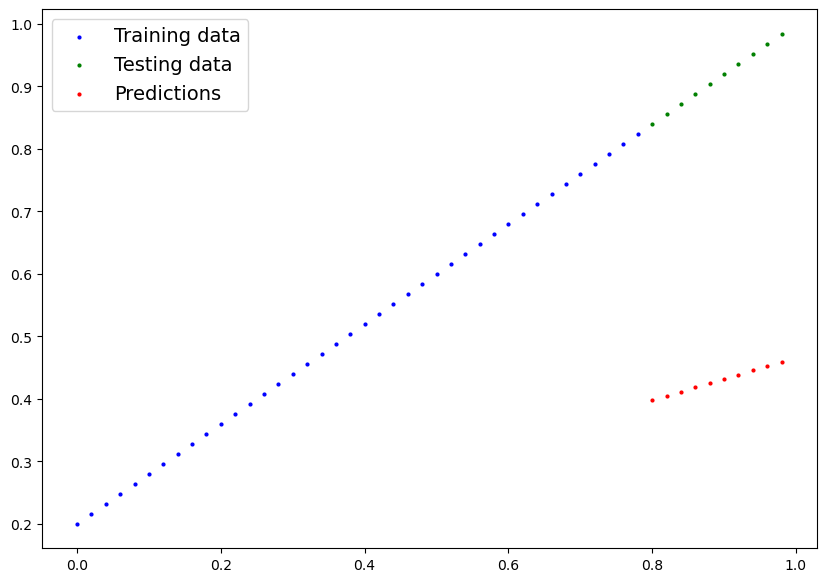

In [13]:
plot_predictions(predictions=y_preds)

The predictions look very bad!


## 3. Train Model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.



In [14]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch

Now we've got a loss function and an optimizer, it's now time to create a training loop (and testing loop)

In [15]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.25188133120536804 | MAE Test Loss: 0.470065176486969 
Epoch: 10 | MAE Train Loss: 0.14190271496772766 | MAE Test Loss: 0.33994418382644653 
Epoch: 20 | MAE Train Loss: 0.09042375534772873 | MAE Test Loss: 0.2502245604991913 
Epoch: 30 | MAE Train Loss: 0.07359591871500015 | MAE Test Loss: 0.19869937002658844 
Epoch: 40 | MAE Train Loss: 0.06710202991962433 | MAE Test Loss: 0.1696048378944397 
Epoch: 50 | MAE Train Loss: 0.06304941326379776 | MAE Test Loss: 0.152482807636261 
Epoch: 60 | MAE Train Loss: 0.059559416025877 | MAE Test Loss: 0.14146271347999573 
Epoch: 70 | MAE Train Loss: 0.05606941506266594 | MAE Test Loss: 0.13044264912605286 
Epoch: 80 | MAE Train Loss: 0.05263061448931694 | MAE Test Loss: 0.1221701130270958 
Epoch: 90 | MAE Train Loss: 0.04919297620654106 | MAE Test Loss: 0.11458444595336914 


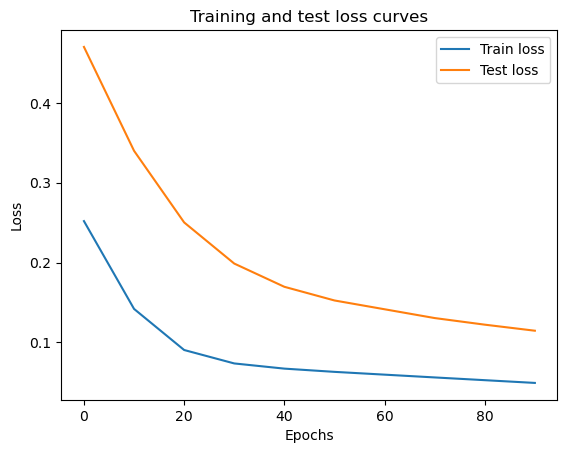

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [17]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5724])), ('bias', tensor([0.2958]))])

And the original values for weights and bias are:
weights: 0.8, bias: 0.2


## 4. Making predictions with a trained PyTorch model (inference)

In [18]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.7538],
        [0.7652],
        [0.7767],
        [0.7881],
        [0.7995],
        [0.8110],
        [0.8224],
        [0.8339],
        [0.8453],
        [0.8568]])

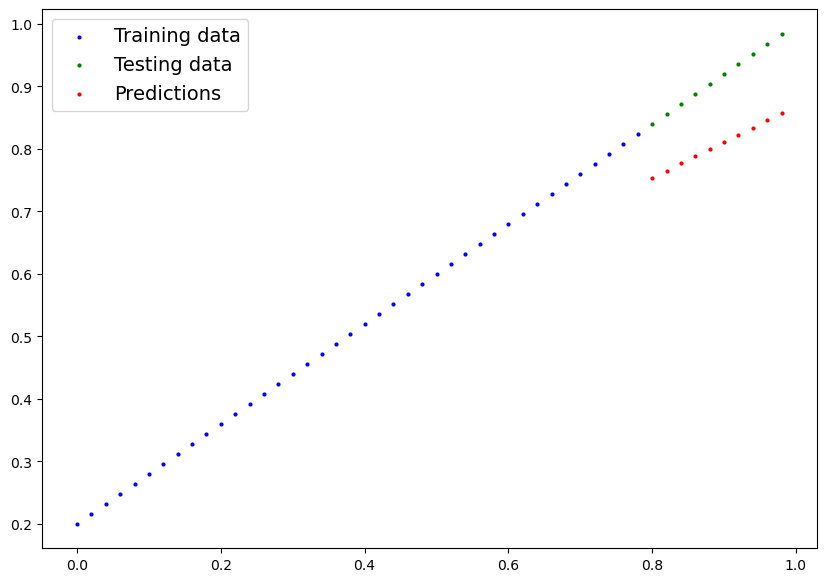

In [19]:
plot_predictions(predictions=y_preds)

Wowwwwwwwwwwwwww, Those red dots are lookign far closer than they were before!